In [1]:
from transformers import GPT2Tokenizer
from torch.nn import CrossEntropyLoss
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset

In [2]:
# Import stuff
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Union, Optional, Tuple, Literal
from functools import partial

import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, ActivationCache

# pio.renderers.default = "colab"
device = "cuda" if torch.cuda.is_available() else "cpu"
if not torch.cuda.is_available():
    print("WARNING: Running on CPU. Did you remember to set your Colab accelerator to GPU?")
torch.set_grad_enabled(False)

In [3]:
from torch.utils.data import DataLoader, Dataset
label_map = {"negative": 0, "positive": 1}
class IMDBDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.texts = dataset["review"]
        self.labels = [label_map[label] for label in dataset["sentiment"]]
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = encodings["input_ids"].squeeze()
        attention_mask = encodings["attention_mask"].squeeze()
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return input_ids, attention_mask, label, idx
    
class SentimentClassifier(nn.Module):
    def __init__(self, transformer, hidden_dim=768, num_classes=2):
        super(SentimentClassifier, self).__init__()
        self.transformer = transformer
        self.classifier = nn.Linear(50257, num_classes)  # Maps hidden state → sentiment classes

    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(input_ids)  # (batch, seq_len, hidden_dim)
        pooled_output = outputs.mean(dim=1)  # Mean pool across sequence length
        logits = self.classifier(pooled_output)  # Shape: (batch_size, 2)
        return logits

import torch
from transformer_lens import HookedTransformer
# load the base model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Load HookedTransformer GPT-2 model
base_model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Create the sentiment classifier model
base_classifier = SentimentClassifier(base_model).to(device)

data_path = "/home/sohampoddar/HDD2/utsav/Dataset/IMDB Dataset.csv"
# Load IMDB dataset (3000 train, 1000 test)
dataset = load_dataset('csv', data_files= data_path)
train_subset = dataset["train"].shuffle(seed=42).select(range(7000))
test_subset = dataset["train"].shuffle(seed=42).select(range(2000))
dataset = {"train": train_subset, "test": test_subset}

test_dataset = IMDBDataset(dataset["test"], tokenizer)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

finetuned_model = SentimentClassifier(base_model).to(device)
finetuned_model.load_state_dict(torch.load("/home/sohampoddar/HDD2/utsav/MI/gpt2-imdb-finetuned.pt"))

Loaded pretrained model gpt2-small into HookedTransformer


<All keys matched successfully>

Edge Attribution Patching 

In [5]:
import spacy 
nlp = spacy.load("en_core_web_sm")
sentence = "The movie was fantastic but the ending was disappointing."
doc = nlp(sentence)

# Extract dependency edges
edges = []
for token in doc:
    edges.append((token.head.text, token.text, token.dep_))  # (head, dependent, relationship)

print(edges)

[('movie', 'The', 'det'), ('was', 'movie', 'nsubj'), ('was', 'was', 'ROOT'), ('was', 'fantastic', 'acomp'), ('was', 'but', 'cc'), ('ending', 'the', 'det'), ('was', 'ending', 'nsubj'), ('was', 'was', 'conj'), ('was', 'disappointing', 'acomp'), ('was', '.', 'punct')]


In [6]:
def predict_sentiment(text, model, tokenizer):
    model.eval()  # Ensure model is in eval mode

    # Tokenize input text
    encoding = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    # Get logits from the model
    with torch.no_grad():
        logits = model(input_ids, attention_mask) # we can print logits etc here

    # Convert logits to probabilities
    probs = torch.softmax(logits, dim=-1)
    pred_label = torch.argmax(probs, dim=-1).item()

    # Map label to sentiment
    sentiment_map = {0: "Negative", 1: "Positive"}
    return sentiment_map[pred_label], probs.cpu().numpy()

In [15]:
original_text = "The movie was fantastic but the ending was disappointing."
original_sentiment , org_prob = predict_sentiment(original_text,finetuned_model, tokenizer)
org_prob
for edge in edges:
    head, dependent, relation = edge
    # Mask the dependent word
    modified_text = original_text.replace(dependent, "[MASK]")
    modified_sentiment , mod_prob  = predict_sentiment(modified_text, finetuned_model, tokenizer)
    
    # conver to tensor 
    mod_prob = torch.tensor(mod_prob)
    org_prob = torch.tensor(org_prob)
    # Compute the difference in sentiment
    sentiment_diff = torch.abs(mod_prob - org_prob).sum().item()
    print(f"Edge: {head} -> {dependent} ({relation}), Sentiment Change: {sentiment_diff:.4f}")

Edge: movie -> The (det), Sentiment Change: 0.1623
Edge: was -> movie (nsubj), Sentiment Change: 0.1920
Edge: was -> was (ROOT), Sentiment Change: 0.3502
Edge: was -> fantastic (acomp), Sentiment Change: 0.4079
Edge: was -> but (cc), Sentiment Change: 0.1578
Edge: ending -> the (det), Sentiment Change: 0.2406
Edge: was -> ending (nsubj), Sentiment Change: 0.1501


/tmp/ipykernel_1551024/855940221.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  org_prob = torch.tensor(org_prob)


Edge: was -> was (conj), Sentiment Change: 0.3502
Edge: was -> disappointing (acomp), Sentiment Change: 0.1243
Edge: was -> . (punct), Sentiment Change: 0.0697


Layer Activations Monitoring and Masking the Last Token

In [5]:
s = "Hello how are you" #  Change this to a sentence (fragment) of your choice, to see what the next tokens are!
logits = base_model(s).squeeze(0).cpu()
probs = torch.softmax(logits, dim=-1)

# let's see what the top 5 predictions are
probs, next_tokens = torch.topk(probs[-1], 5)
print(s, "...")
for token_id, prob in zip(next_tokens, probs):
    token = base_model.tokenizer.decode(token_id.item())
    print(f"{token.strip()}\t {prob.item():.3f}")

Hello how are you ...
	 0.009
the	 0.005
of	 0.005
.	 0.005
a	 0.005


In [13]:
# make a corrupt dataset random word substitution

# Simple sentiment replacement dictionary
sentiment_swaps = {
    # Positive → Negative
    "great": "bad", "amazing": "boring", "fantastic": "terrible", "excellent": "awful", "superb": "horrible",
    "love": "dislike", "enjoyed": "hated", "wonderful": "dreadful", "brilliant": "dull", "beautiful": "ugly",
    "outstanding": "mediocre", "charming": "unpleasant", "impressive": "unremarkable", "delightful": "disappointing",
    "spectacular": "ordinary", "thrilling": "boring", "engaging": "tedious", "fascinating": "uninspiring",
    "masterpiece": "mess", "heartwarming": "cold", "touching": "emotionless", "captivating": "lifeless",
    "compelling": "flat", "entertaining": "dull", "refreshing": "stale", "mesmerizing": "forgettable",
    
    # Negative → Positive
    "bad": "good", "boring": "exciting", "awful": "nice", "terrible": "fantastic", "horrible": "amazing",
    "hate": "love", "dull": "brilliant", "ugly": "beautiful", "mediocre": "outstanding", "unpleasant": "charming",
    "unremarkable": "impressive", "disappointing": "delightful", "ordinary": "spectacular", "tedious": "engaging",
    "uninspiring": "fascinating", "mess": "masterpiece", "cold": "heartwarming", "emotionless": "touching",
    "lifeless": "captivating", "flat": "compelling", "stale": "refreshing", "forgettable": "mesmerizing"
}

def corrupt_text(text):
    words = text.split()
    corrupted_words = [sentiment_swaps.get(word.lower(), word) for word in words]
    return " ".join(corrupted_words)

# apply to the dataset 
corrupted_dataset = dataset["test"].map(lambda x: {"review": corrupt_text(x["review"])})

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [14]:
def prob_diff(logits: torch.Tensor, labels: torch.Tensor):
    probs = torch.softmax(logits, dim=-1).to(device)  # Convert logits to probabilities
    labels = labels.to(device)
    correct_probs = probs.gather(1, labels.unsqueeze(1)).squeeze(1).to(device)  # True class probs
    incorrect_probs = 1 - correct_probs  # Since binary: P(incorrect) = 1 - P(correct)

    return correct_probs - incorrect_probs 

In [15]:
# batch the dataset
corrupted_dataset = IMDBDataset(corrupted_dataset, tokenizer)
corrupted_loader = DataLoader(corrupted_dataset, batch_size=4, shuffle=True)
clean_dataset = dataset["test"]
clean_dataset = IMDBDataset(clean_dataset, tokenizer)
clean_loader = DataLoader(clean_dataset, batch_size=4, shuffle=True)



Average Probability Difference (Clean): 0.8296
Average Probability Difference (Corrupted): 0.6188


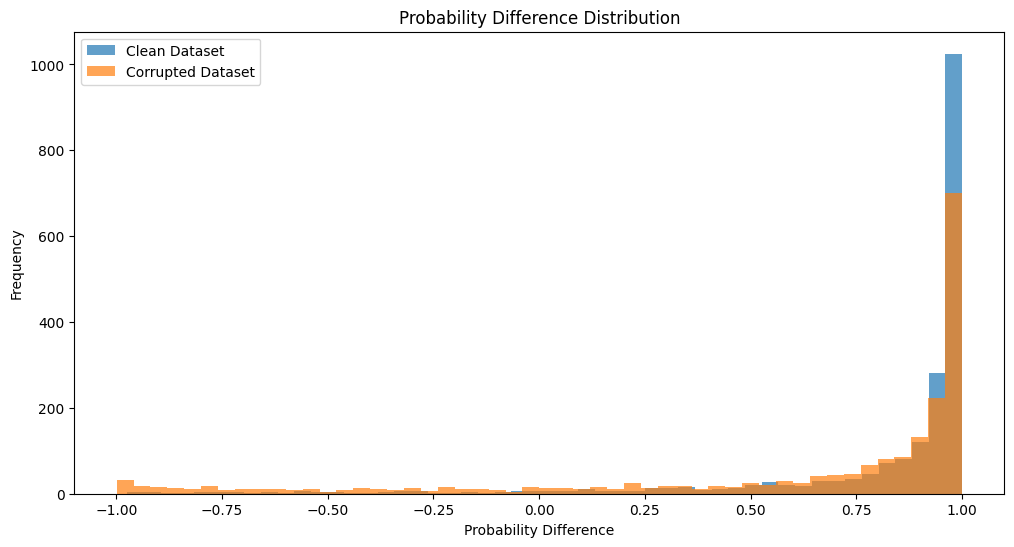

In [16]:

# loop through the dataset and get the probability difference
clean_diffs = []
corrupted_diffs = []

for (clean_batch, corrupted_batch) in zip(clean_loader, corrupted_loader):
    clean_input_ids, clean_attention_mask, clean_labels, _ = clean_batch
    corrupted_input_ids, corrupted_attention_mask, corrupted_labels, _ = corrupted_batch

    # Get logits for clean and corrupted batches
    clean_logits = finetuned_model(clean_input_ids.to(device), clean_attention_mask.to(device))
    corrupted_logits = finetuned_model(corrupted_input_ids.to(device), corrupted_attention_mask.to(device))

    # Compute probability differences

    clean_diffs.extend(prob_diff(clean_logits, clean_labels))
    corrupted_diffs.extend(prob_diff(corrupted_logits, corrupted_labels))

    # # print clean_diffs
    # print("Clean Diffs: ", clean_diffs)
    # print("Corrupted Diffs: ", corrupted_diffs)

# print avg diff
clean_diffs = torch.stack(clean_diffs).cpu().numpy()
corrupted_diffs = torch.stack(corrupted_diffs).cpu().numpy()
print(f"Average Probability Difference (Clean): {clean_diffs.mean():.4f}")
print(f"Average Probability Difference (Corrupted): {corrupted_diffs.mean():.4f}")
# Plot the probability differences
plt.figure(figsize=(12, 6))
plt.hist(clean_diffs, bins=50, alpha=0.7, label="Clean Dataset")
plt.hist(corrupted_diffs, bins=50, alpha=0.7, label="Corrupted Dataset")
plt.xlabel("Probability Difference")
plt.ylabel("Frequency")
plt.legend()
plt.title("Probability Difference Distribution")
plt.show()